# 5.0 Predicting LTV - Modeling

## 5.1 Introduction

Online Retail, a company specializing in e-commerce, recently invested a substantial portion of its revenue in an advertising campaign to boost brand and product awareness. Despite these efforts, the campaign achieved an acquisition response rate of only 3%, falling short of the anticipated 6%. Management suspects that the campaign's underperformance stemmed from its broad and costly approach, which failed to consider the diverse purchasing behaviors of customers.

To improve outcomes, the company intends to focus future marketing efforts on customers most likely to drive revenue growth. With the next campaign scheduled in six months, management seeks to achieve the following objectives:

Customer Value Analysis: Assess the commercial value of each customer just before the campaign launch.
Customer Segmentation: Develop a segmentation strategy based on purchasing behaviors to identify key customer groups.
Marketing Enablement Tool: Equip the Marketing team with a tool to implement and sustain a targeted marketing strategy.
The Data Science team has been tasked with leading this project. They will collaborate with the Marketing team responsible for promotions, the Technology team, and a Management Committee representative. Although the company's database contains some data gaps due to past system migrations, it will serve as the foundation for this initiative. The success of this project will be evaluated based on the achievement of the targeted response rate of 6%, a key performance metric set by management.

It was produced using information available in the customer database which contains 33 variables for each customer. The approach adopted is:
 • Retain the 'LTV' column as an explanatory or independent variable
 • Determine to what extent each of the other variables allows predicting the explanatory variable
 • Retain the most relevant variables to develop a model based on the regression mode with the smallest absolute error

This document is the continuation of Feature engineering.
It contains:
 - analysis of three models and their performance
 - choice of the model to identify customers likely to churn
   

## 5.2 Import the necessary libraries

In [1]:
# Code task 1#
# Import common libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint

In [2]:
# Code task 2#
# Import Machine Learning models:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.stats import randint
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge

In [3]:

# Data Preprocessing
def preprocess_data(data):
    """Preprocess the data by handling missing values and encoding categorical features."""
    # Handling missing values
    data = data.dropna()

    # Encoding categorical variables (if any)
    data = pd.get_dummies(data, drop_first=True)
    
    print("Data preprocessing completed.")
    return data

# Splitting data
def split_data(data, target_column):
    """Split the data into training and testing sets."""
    X = data.drop(columns=[target_column])
    y = data[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print("Data split into training and testing sets.")
    return X_train, X_test, y_train, y_test

# Model Training
def train_model(X_train, y_train):
    """Train a Random Forest model using GridSearchCV."""
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_

# Model Evaluation
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and display performance metrics."""
    y_pred = model.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred, average='weighted'):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred, average='weighted'):.2f}")

# Feature Importance
def plot_feature_importance(model, feature_names):
    """Plot feature importance for RandomForestClassifier."""
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices], align="center")
        plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("Model does not support feature importances.")

## 5.3 Import the data

In [4]:
# Code task 3#
# Import the initial data
customer_data = pd.read_csv('customer_data.csv')
# Import the transform data
df = pd.read_csv("custommer_class.csv")
df.head().T

,0,1,2,3,4
CustomerID,12346.0,12747.0,12748.0,12749.0,12820.0
Revenue,0.0,2091.4,9786.54,782.1,170.46
TotalTransactions,2,6,95,2,1
AvgOrderValue,0.0,38.025455,6.777382,14.483333,15.496364
Frequency,2,55,1444,54,11
Recency,142,15,0,16,143
Tenure,1,171,190,14,1
RecencyCluster2,2,0,0,0,2
FrequencyCluster2,0,0,4,0,0
RevenueCluster2,0,0,1,0,0


In [5]:
# Code task 4
# Check on the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2570 entries, 0 to 2569
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           2570 non-null   float64
 1   Revenue              2570 non-null   float64
 2   TotalTransactions    2570 non-null   int64  
 3   AvgOrderValue        2570 non-null   float64
 4   Frequency            2570 non-null   int64  
 5   Recency              2570 non-null   int64  
 6   Tenure               2570 non-null   int64  
 7   RecencyCluster2      2570 non-null   int64  
 8   FrequencyCluster2    2570 non-null   int64  
 9   RevenueCluster2      2570 non-null   int64  
 10  Overall_Score        2570 non-null   int64  
 11  Future6MonthRevenue  2570 non-null   float64
 12  LTVCluster           2570 non-null   int64  
 13  Segment_High-Value   2570 non-null   bool   
 14  Segment_Low-Value    2570 non-null   bool   
 15  Segment_Mid-Value    2570 non-null   b

## 5.3 Correlation of features against labels

In [6]:
# Code task 5#
# Correlation between the independant variables and the dependant variable
correlation_matrix = df.corr()
label_matrix = correlation_matrix['LTVCluster']
label_matrix

CustomerID            -0.006319
Revenue                0.654042
TotalTransactions      0.555012
AvgOrderValue          0.158992
Frequency              0.416424
Recency               -0.197934
Tenure                 0.314373
RecencyCluster2       -0.189172
FrequencyCluster2      0.345228
RevenueCluster2        0.680915
Overall_Score          0.179475
Future6MonthRevenue    0.644445
LTVCluster             1.000000
Segment_High-Value     0.169334
Segment_Low-Value     -0.158482
Segment_Mid-Value      0.137919
Name: LTVCluster, dtype: float64

The correlation matrix reveal:

- Revenue has a strong positive correlation with "Future6MonthRevenue."
- TotalTransactions: The number of transactions a customer has made can be a good predictor of their future revenue.
- AvgOrderValue: The average value of a customer's orders can also be an important factor.
- Frequency: How often a customer makes purchases can be a strong indicator of their future value.
- Recency: The time since the last purchase can provide insights into customer behavior.
- Tenure: The length of time a customer has been with the company can also be relevant.

## 5.4 Machine Learning models:

### 5.4.1 Type of Machine Learning model

Predicting the Lifetime Value (LTV) of a customer is fundamentally a linear regression problem. A machine learning model can estimate the monetary value of each customer over a specified period, which in this case is six months. However, presenting this information to stakeholders as a list of all customers with their respective LTVs would be impractical. Therefore, we have transformed the regression problem into a multi-classification problem by segmenting the dependent variable "Future6MonthRevenue" into three categories:

    - Top_LTV
    - High_LTV
    - Med_LTV
    - Low_LTV

The machine learning model will classify each customer into one of these segments. This approach makes the information more understandable for all stakeholders.

The following three models will be evaluated to retain the most efficient ones:
  - K-Nearest Neighbors (KNN)
  - Random Forest
  - Gradient Boost

The approach adopted is as follows:
  - Using "GreadSearch" and "RandomizedSearch" to determine the hyperparameters that lead to the best scores for each model.
  - Create the model from the hyperparameters obtained from the search.
  - Evaluate models'performance and perform a cross-validation to ensure the stability of the scores without overfitting the model
  - Using Accuracy and Recall to evaluate the performance of the models
  - Generate for each model the "confusion matrix"' and the classification report


## 5.5 Split de Data into Training and Test

In [7]:
# Code task 7#
# Remove the column 'CustomerID' which will not include in the model
df = df.drop(['CustomerID'], axis=1)

In [8]:
# Code task 8#
# Dependant variable or target: LVT
y = df['LTVCluster']

# Code task 9#
# Independant variables or features
X = df.drop(['Future6MonthRevenue','LTVCluster','AvgOrderValue'], axis=1)

### 5.5.1 Resample X and y to address the problem of unbalanced clusters

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42, k_neighbors=1)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [10]:
# Code task 10#
# Split the data in train and test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

## 5.6 Scale The Data

In [11]:
#Code task 11#
# Initialize the StandardScaler()
scaler = StandardScaler()

#Code task 12#
# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

#Code task 13#
# Transform the testing data
X_test_scaled = scaler.transform(X_test)

### 5.7.1 k-Nearest Neighbors (k-NN)

In [12]:
# Code task 14#
# Instantiate the KNN classifier
knn = KNeighborsClassifier()

#### 5.7.1-2 Identifying the best parameters

##### 5.7.1-2.1 Using GridSearch

In [13]:
# Code task 15#
# Define the parameter grid
param_grid = { 'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 40],
              'p': [1, 2] }

# Code task 16#
# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Code task 17#
# Fit GridSearchCV to the data
grid_search.fit(X_train_scaled, y_train)

# Code task 18#
# Print the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

# Code task 19#
# Get the best parameters
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')


Best Parameters:  {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best Score:  0.9658440918617123
Best parameters found: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


##### 5.7.1-2.2 Using RandomizedSearchCV

In [14]:
# Code task 20#
# Define the parameter distribution
param_grid = { 'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 40],
              'p': [1, 2] }

# Code task 21#
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(knn, param_grid, cv=5, scoring='accuracy',random_state=42)

# Code task 22#
# Fit RandomizedSearchCV to the data
random_search.fit(X_train_scaled, y_train)

# Code task 23#
# Print the best parameters and the best score
print('Best Parameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

# Code task 24#
# Get the best parameters
best_params = random_search.best_params_
print(f'Best parameters found: {best_params}')


Best Parameters:  {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'leaf_size': 40, 'algorithm': 'ball_tree'}
Best Score:  0.9647928435042876
Best parameters found: {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'leaf_size': 40, 'algorithm': 'ball_tree'}


##### GridSearch and RandomizedSearchCV slightly lead to the same score. We will retain the hyperparameters of the RandomizedSearch with the higher n_neighbors

#### 5.7.1-3 The Model

In [15]:
# Code task 26#
# Instantiate the model
knn1 = KNeighborsClassifier(weights='uniform', p=2, n_neighbors = 9, leaf_size= 10, algorithm= 'auto')

# Code task 27#
# Fit the model
knn1.fit(X_train_scaled, y_train)

KNeighborsClassifier(leaf_size=10, n_neighbors=9)

#### 5.7.1-4 Evaluate the Model

##### 5.7.1-4.1 Accuracy of knn1

In [16]:
# Code task 27#
# Use the score method to determine the accuracy
accuracy_score_knn1 = knn1.score(X_test_scaled, y_test)
print(accuracy_score_knn1)

0.9495798319327731


##### 5.7.1-4.2 Cross-Validation

In [17]:
# Code task 28#
# Define the KFold Cross-Validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Code task 29#
#Cross-Validation
n_neighbors_train_results = cross_val_score(knn1, X_train, y_train, cv=kf,scoring='accuracy' )
accuracy_train_knn = n_neighbors_train_results.mean() # Choose the mean accuracy as the accuracy of the model

# Code task 30#
# Predict on the test set
y_pred = knn1.predict(X_test_scaled)

# Code task 31#
# Evaluate the model on the test set
accuracy_test_knn = accuracy_score(y_test, y_pred)

# Code task 32#
print(f'n_neighbors_train_results = {n_neighbors_train_results}')
print(f'accuracy_train_knn = {accuracy_train_knn}')
print(f'accuracy_knn1_test = {accuracy_test_knn}')

n_neighbors_train_results = [0.94247439 0.94168637 0.94720252 0.95429472 0.95425868 0.95347003]
accuracy_train_knn = 0.9488977841747603
accuracy_knn1_test = 0.9495798319327731


##### The selected n_neighbors leads to an overall training recall of 0.979, which is close to the highest values in your list. This suggests a near-optimal parameter have been choosen.

##### The test recall is  which is slightly higher than the training recall (0.979). This could indicate that the model generalizes well to unseen data and is not overfitting

##### 5.7.1-4.3 Confusion Matrix

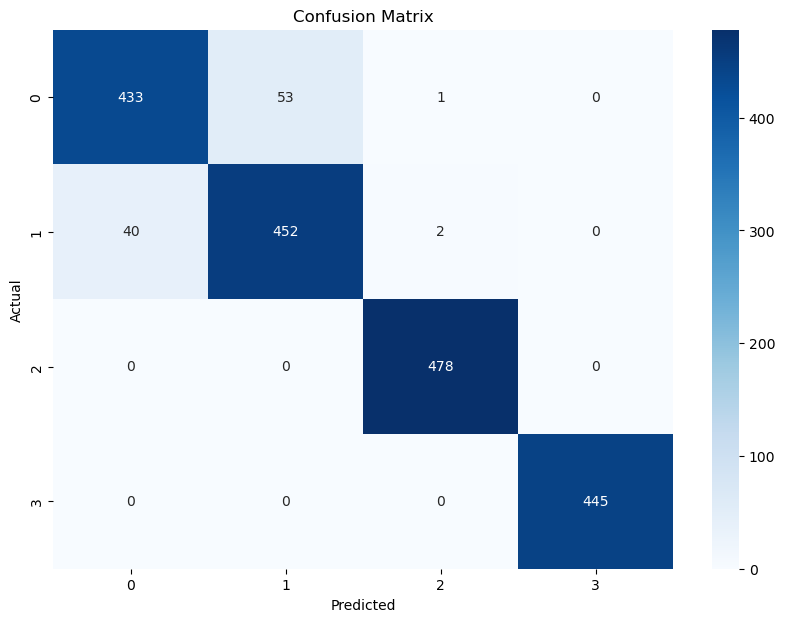

[[433  53   1   0]
 [ 40 452   2   0]
 [  0   0 478   0]
 [  0   0   0 445]]


In [18]:
# Code task 33#
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)

# Code task 34#
# Create a label encoder
le = LabelEncoder()

# Code task 35#
# Fit and transform the labels
df['LVT_encoded'] = le.fit_transform(df['LTVCluster'])


# Code task 36#
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.show()
print(confusion_matrix(y_test, y_pred))

##### 5.7.1-4.4 Classification Report

In [19]:
# Code task 37#
# Define labels
class_labels = ['Low_LVT','Med_LVT','High_LVT','Top_LVT' ]

# Code task 38#
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

     Low_LVT       0.92      0.89      0.90       487
     Med_LVT       0.90      0.91      0.90       494
    High_LVT       0.99      1.00      1.00       478
     Top_LVT       1.00      1.00      1.00       445

    accuracy                           0.95      1904
   macro avg       0.95      0.95      0.95      1904
weighted avg       0.95      0.95      0.95      1904



### 5.7.2 Random Forest

In [20]:
# Code task 39#
# Instantiate the model
rf = RandomForestClassifier()

#### 5.5.2-1 Identifying the best parameters

##### 5.5.2-1.1 Using GridSearchCV

In [21]:
# Code task 40#
# Define the parameter grid
param_grid = {'n_estimators':[100,200,300],
              'max_depth':[None, 10,20,30],
              'min_samples_split':[2, 5, 10, 15],
              'min_samples_leaf':[1, 2, 4, 6],
              'max_features': ['sqrt', 'log2',None],
              'bootstrap':[True, False]
             }
# Code task 41#
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Code task 42#
# Fit the model
grid_search.fit(X_train, y_train)

# Code task 43#
# Print the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Best Parameters:  {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score:  0.9844985733427782


##### 5.5.2-1.2 Using RandomizedSearchCV

In [22]:
# Code task 44#
# Define the parameter distribution
param_dist ={
    'n_estimators': randint(100,500),
    'max_depth':[None, 10, 20, 30, 40],
    'min_samples_split': randint(2,20),
    'min_samples_leaf': randint(1,10),
    'max_features':[None,'sqrt','log2'],
    'bootstrap':[True, False]
}

# Code task 45#
# Instantiate the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions= param_dist,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Code task 46#
# Fit the model
random_search.fit(X_train, y_train)

# Code task 47#
# Print the best parameters and the best score
print('Best Parameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 200}
Best Score:  0.9835791624353


##### The parameters obtained using GridSearchCV lead to a better score. We will retain them for the model

#### 5.5.2-2 The Model

In [23]:
# Code task 48#
# Instantiate the model
rf1 = RandomForestClassifier(n_estimators= 100 , max_depth= None,
                             min_samples_split= 15 , min_samples_leaf= 1 ,
                             max_features='sqrt' , bootstrap=False)

# Code task 49#
# Fit the model
rf1.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, min_samples_split=15)

#### 5.5.2-3 Evaluate the Model

##### 5.5.2-3.1 Accuracy

In [24]:
# Code task 49#
# Use the score method to assess the accuracy of the model
accuracy_rf = rf1.score(X_test, y_test)
print(accuracy_rf)

0.9821428571428571


##### 5.5.2-3.4 Cross-Validation

In [25]:
# Code task 50#
# Define the KFold Cross-Validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Code task 51#
#Cross-Validation
random_forest_train_results = cross_val_score(rf1, X_train, y_train, cv=kf, scoring='accuracy')
accuracy_train_rf = random_forest_train_results.mean()

# Code task 52#
# Predict on the test set
y_pred = rf1.predict(X_test)

# Code task 53#
# Evaluate the model on the test set
accuracy_test_rf = accuracy_score(y_test, y_pred)

# Code task 54#
# Print the performance
print(random_forest_train_results)
print(f'accuracy_train_rf = {accuracy_train_rf}')
print(f'accuracy_test_rf = {accuracy_test_rf}')


[0.97951143 0.98108747 0.98187549 0.98660362 0.98028391 0.98659306]
accuracy_train_rf = 0.9826591642988718
accuracy_test_rf = 0.9821428571428571


##### 5.5.2-3.2 Confusion Matrix

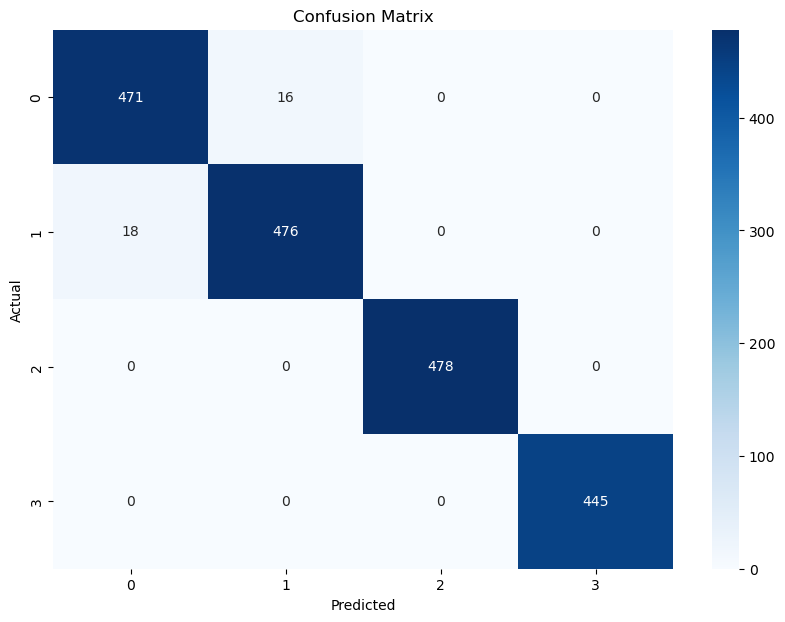

[[471  16   0   0]
 [ 18 476   0   0]
 [  0   0 478   0]
 [  0   0   0 445]]


In [26]:
# Code task 55#
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)

# Code task 56#
# Create a label encoder
le1 = LabelEncoder()

# Code task 57#
# Fit and transform the labels
df['LVT_encoded'] = le1.fit_transform(df['LTVCluster'])


# Code task 58#
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le1.classes_, yticklabels=le1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()
print(confusion_matrix(y_test, y_pred))

##### 5.5.2-3.3 Classification Report

In [27]:
# Code task 59#
# Define the labels for the classification report
class_labels = ['Low_LVT','Med_LVT','High_LVT','Top_LVT']

# Code task 60#
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

     Low_LVT       0.96      0.97      0.97       487
     Med_LVT       0.97      0.96      0.97       494
    High_LVT       1.00      1.00      1.00       478
     Top_LVT       1.00      1.00      1.00       445

    accuracy                           0.98      1904
   macro avg       0.98      0.98      0.98      1904
weighted avg       0.98      0.98      0.98      1904



The test recall is slightly higher than the training recall, which is unusual but not alarming

### 5.5.3 Gradient Boosting

In [28]:
# Code task 70#
# Intantiate the model
gbc = GradientBoostingClassifier()

#### 5.5.3-1 Identifying the best parameters

##### 5.5.3-1.1 Using GridSearch

In [29]:
# Code task 71#
# Define the Grid parameters
param_grid = { 'n_estimators': [100, 200, 300],
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': [3, 4, 5],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2',None]
             }

# Code task 72#
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Code task 73#
# Fit the model
grid_search.fit(X_train, y_train)

# Code task 74#
# Print the best parameters and best score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters:  {'learning_rate': 0.2, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best Score:  0.9825279140778755


##### 5.5.3-1.2 Using RandomizedSearchCV

In [30]:
# Code task 75#
# Define the parameter distribution
param_dist = { 'n_estimators': randint(100, 500),
              'learning_rate': [0.01, 0.1, 0.2],
              'max_depth': randint(3, 10),
              'min_samples_split': randint(2, 20),
              'min_samples_leaf': randint(1, 10),
              'max_features': ['sqrt', 'log2',None]
             }

# Code task 76#
# Instantiate the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbc, param_distributions= param_dist,
                                   n_iter=100, cv=5, n_jobs=-1, verbose=2, random_state=42)

# Code task 77#
# Fit the model
random_search.fit(X_train, y_train)

# Code task 78#
# Print the best parameters and the best score
print('Best Parameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters:  {'learning_rate': 0.2, 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 10, 'n_estimators': 306}
Best Score:  0.9838414568383345


##### RandomizedSearch leads to the best score in the case of the Gradient Boosting Model. We'll use its parameters to build our model

### 5.5.3-2 The Model

In [37]:
# Code task 79#
# Instantiate the model
gbc1 = GradientBoostingClassifier(n_estimators =200,
              learning_rate =0.2,
              max_depth =9,
              min_samples_split=10,
              min_samples_leaf=7,
              max_features= 'log2')

# Code task 80#
# Fit the model
gbc1.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_depth=9, max_features='log2',
                           min_samples_leaf=7, min_samples_split=10,
                           n_estimators=200)

### 5.5.3-3 Evaluate the model

#### 5.5.3-3.1 Accuracy

In [38]:
# Code task 81#
# Use the score method to calculate the accuracy of the model
accuracy_gbc = gbc1.score(X_test, y_test)
print(accuracy_gbc)

0.9868697478991597


#### 5.5.3-3.4 Cross-Validation

In [39]:
# Code task 82#
# Define the KFold Cross-Validation
kf = KFold(n_splits=6, shuffle=True, random_state=42)

# Code task 83#
#Cross-Validation
gradient_boostin_train_results = cross_val_score(gbc1, X_train_scaled, y_train, cv=kf, scoring='accuracy')
accuracy_train_gbc = gradient_boostin_train_results.mean()

# Code task 84#
# Predict on the test set
y_pred = gbc1.predict(X_test)

# Code task 85#
# Evaluate the model on the test set
accuracy_test_gbc = accuracy_score(y_test, y_pred)

# Code task 86#
print(gradient_boostin_train_results)
print(f'accuracy_train_gbc= {accuracy_train_gbc}')
print(f'accuracy_test_gbc = {accuracy_test_gbc}')

[0.97951143 0.98423956 0.98266351 0.98502758 0.98501577 0.98817035]
accuracy_train_gbc= 0.9841047000420112
accuracy_test_gbc = 0.9868697478991597


#### 5.5.3-3.2 Confusion Matrix

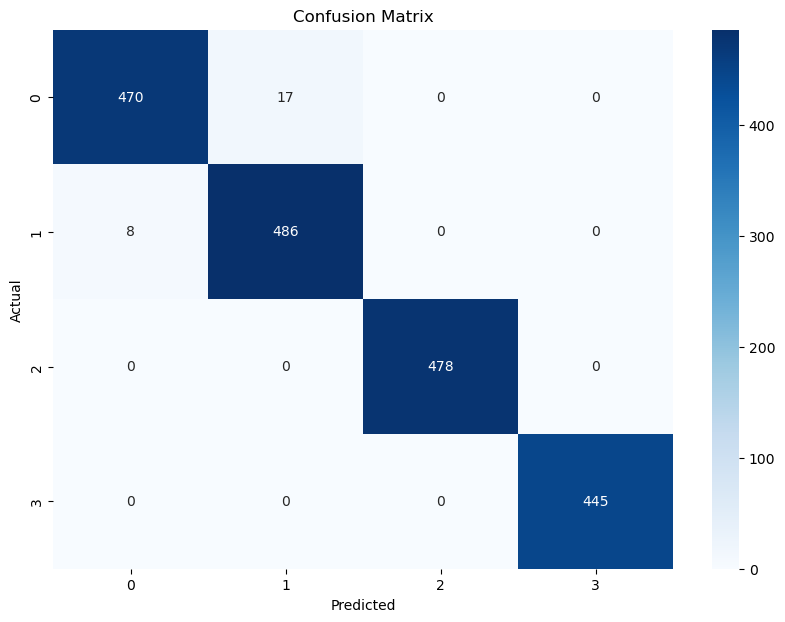

[[470  17   0   0]
 [  8 486   0   0]
 [  0   0 478   0]
 [  0   0   0 445]]


In [40]:
# Code task 87#
# Confusion Matrix
cm= confusion_matrix(y_test, y_pred)

# Code task 88#
# Create a label encoder
le1 = LabelEncoder()

# Code task 89#
# Fit and transform the labels
df['LVT_encoded'] = le1.fit_transform(df['LTVCluster'])


# Code task 90#
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le1.classes_, yticklabels=le1.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()
print(confusion_matrix(y_test, y_pred))

#### 5.5.3-3.3 Classification Report

In [41]:
# Code task 91#
# Define the labels for the classification report
class_labels = ['Low_LVT','Med_LVT','High_LVT','Top_LVT']

# Code task 92#
# Generate the classification report
report = classification_report(y_test, y_pred, target_names=class_labels)
print(report)


              precision    recall  f1-score   support

     Low_LVT       0.98      0.97      0.97       487
     Med_LVT       0.97      0.98      0.97       494
    High_LVT       1.00      1.00      1.00       478
     Top_LVT       1.00      1.00      1.00       445

    accuracy                           0.99      1904
   macro avg       0.99      0.99      0.99      1904
weighted avg       0.99      0.99      0.99      1904



## 5.6 Comparison of the models

In [42]:
# Code task 93#
# Create lists of the performance of the three models
models = ['KNN', 'Random Forest', 'Gradient Boosting']
score_test= [accuracy_test_knn,accuracy_test_rf, accuracy_test_gbc]
score_train =[accuracy_train_knn,accuracy_train_rf, accuracy_train_gbc]
Accuracy_score = [accuracy_score_knn1, accuracy_rf, accuracy_gbc]

# Code task 94#
# Create a DataFrame of the performance of the three models
score_tab = pd.DataFrame(list(zip(models, score_train, score_test,Accuracy_score)), columns =['Model','Accuracy_train','Accuracy_test','Accuracy'])

# Code task 95#
# Display the DataFrame
score_tab

,Model,Accuracy_train,Accuracy_test,Accuracy
0,KNN,0.948898,0.949580,0.949580
1,Random Forest,0.982659,0.982143,0.982143
2,Gradient Boosting,0.984105,0.986870,0.986870


## 5.7 Conclusion

The Gradient Boosting model has the highest accuracy test and accuracy score. For this reason, we keep it as model to assess the Lifetime values of the customers.

The performance of the model is :
Accuracy: 98.6870%
F1-Score: 0.99 globaly.

The model left a place for improvement 


## END